### UKF by Edgar Kraft

#### Implementation of the following paper: https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=1257247

### Import dependencies

In [6]:
from PyAstronomy import pyasl
import numpy as np
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D
import math
from scipy.spatial.transform import Rotation as Rot

from filterpy.kalman import JulierSigmaPoints, UnscentedKalmanFilter
from filterpy.common import Q_discrete_white_noise
from pyquaternion import Quaternion
import matplotlib.mlab as mlab
from scipy.stats import norm

from numpy.linalg import pinv, inv

import tqdm

In [7]:
a_const = 1
f_const = 2*(a_const + 1)
seq_len = 100
ts = np.linspace(0,4,seq_len)
dt = ts[0] - ts[1]
eulers = np.array([np.sin(ts), np.sin(ts), np.sin(ts)]).transpose()
dth = np.array([np.cos(ts), np.cos(ts), np.cos(ts)]).transpose()
q_gt =  np.array([Rot.from_euler('xyz', x).as_quat() for x in eulers])
z_q = np.array([Rot.from_euler('xyz', x + np.random.randn(3)*1e-2).as_quat() for x in eulers])
z_grp = np.zeros((seq_len, 3))
for k in range(seq_len):
    z_grp[k] = q2grp(z_q[k],a_const,f_const,False)

In [8]:
from filterpy.kalman import UnscentedKalmanFilter as UKF, MerweScaledSigmaPoints
q_identity = np.array([0,0,0,1])
def quat_mul(qa, qb):
    # q: (q1, q2, q3, q4), where q4 is scalar
    # shape: (4,)
    qa_ = Quaternion(scalar=qa[3], vector = qa[:3])
    qb_ = Quaternion(scalar=qb[3], vector = qb[:3])
    qc = qa * qb
    qc = np.array([qc[1], qc[2], qc[3], qc[0]])
    return qc

def fx(x, dt):
    xout = np.empty_like(x)
    # state transition function - predict next state based
    # on constant velocity model x = vt + x_0
    # calculate corresponding error quats, Eq. (33)
    alphadelta = np.linalg.norm(x[4:]) * dt
    edelta = x[4:] / np.linalg.norm(x[4:])
    qdelta = np.zeros(4)
    qdelta[:3] = edelta * np.sin(alphadelta/2)
    qdelta[3] = np.cos(alphadelta / 2)    
    
    xout[:4] = quat_mul(x[:4], qdelta)
    xout[:4] = xout[:4] / np.linalg.norm(xout[:4])
    # propagate sigma pt, Eq. (38)
    xout[4:] = x[4:]
    return xout 

def q2grp(q, a=1, f=1, wfirst=False):
    if wfirst:
        return f*(q[1:])/(a+q[0])
    else:
        return f*(q[:3])/(a+q[3])

def hx(x):
    # measurement function - convert state into a measurement 
    # where measurements are [x_pos, y_pos, z_pos]
    return x[:4]

def P_q_to_grp(q, P, a=1):
    x, y, z, w = q

    dgdq0 = [f/(a+w), 0, 0]
    dgdq1 = [0, f/(a+w), 0]
    dgdq2 = [0, 0, f/(a+w)]
    dgdq3 = [-f*x/(a+w)**2, -f*y/(a+w)**2, -f*z/(a+w)**2]

    J = np.array([dgdq0, dgdq1, dgdq2, dgdq3]).transpose()
    return J @ P[:4,:4] @ J.transpose()

def P_q_to_euler(q, P):
    x, y, z, w = q
    denom0 = 4*x**2*(w**2+2*y**2-1) + 8*w*x*y*z + 4*x**4+4*y**4+4*y**2*(z**2-1)+1
    d00 = 2*(2*w*x**2-2*w*y**2+w+4*x*y*z) / denom0
    d01 = 2*(4*w*x*y-2*x**2*z+2*y**2*z+z) / denom0
    d02 = -2*y*(2*x**2+2*y**2-1) / denom0
    d03 = -2*x*(2*x**2+2*y**2 - 1) / denom0
    denom1 = np.sqrt(1 - 4*(w*y - x*z)**2)
    d10 = -2*z / denom1
    d11 = 2*w / denom1
    d12 = -2*x / denom1
    d13 = 2*y / denom1
    denom2 = (4*w**2 - 4) * z**2 + 8*w*x*y*z + y**2 * (4*x**2 + 4*(2*z**2-1)) + 4*y**4 + 4*z**4 + 1
    d20 = -2*y*(2*y**2+2*z**2-1) / denom2
    d21 = 2*(4*w*y*z+2*x*y**2-2*x*z**2+x) / denom2
    d22 = 2*(-2*w*y**2+2*w*z**2+w+4*x*y*z) / denom2
    d23 = -2*z*(2*y**2+2*z**2-1) / denom2

    J = np.array([[d00, d01, d02, d03],[d10, d11, d12, d13],[d20, d21, d22, d23]]).transpose()
    #print(P.shape, J.shape, q.shape)
    return J @ P[:4,:4] @ J.transpose()



In [ ]:
# create sigma points to use in the filter. This is standard for Gaussian processes
dimx = 7
points = MerweScaledSigmaPoints(dimx, alpha=.01, beta=2., kappa=-1)

kf = UnscentedKalmanFilter(dim_x=dimx, dim_z=4, dt=dt, fx=fx, hx=hx, points=points)
kf.P *= 1e-3 # initial uncertainty
z_std = 1e-5
kf.R = np.diag([z_std**2, z_std**2,z_std**2,z_std**2]) # 1 standard
kf.Q *= 1e-4


xhat = np.zeros((seq_len, dimx))
xhat[0,:4] = z_q[0]
xhat[0,4:] = np.random.randn(3)
kf.x = xhat[0]
P = np.zeros((seq_len, dimx, dimx))
for t in tqdm.tqdm(range(seq_len)):

    kf.predict()
    kf.update(z_q[t])

    # store state for record
    xhat[t] = kf.x
    P[t] = kf.P

100%|██████████| 100/100 [00:00<00:00, 549.61it/s]


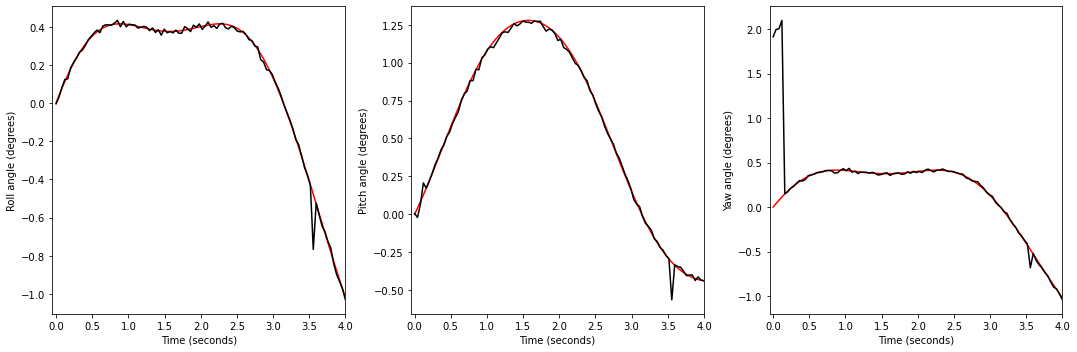

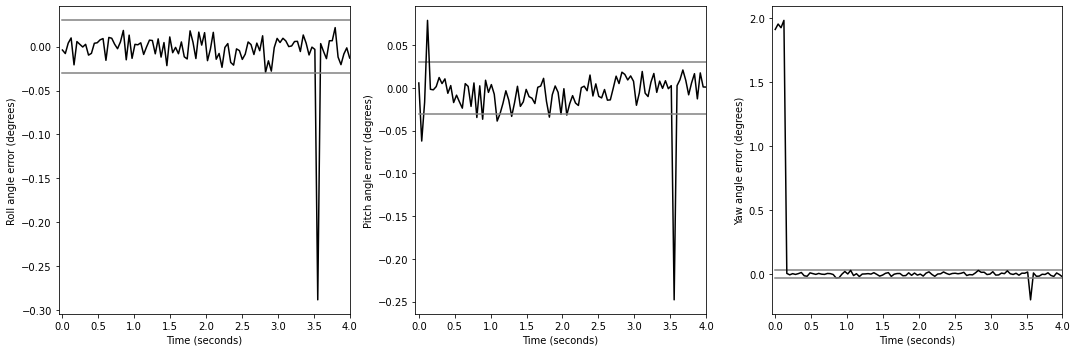

In [19]:


time = ts

e_gt = np.array([q2grp(x[:4], a_const, f_const, False) for x in q_gt])
ehat = np.array([q2grp(x[:4], a_const, f_const, False) for x in xhat])
sig = np.array([np.sqrt(x.diagonal()[:3]) for x in P])

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15,5))

ax1.plot(time, e_gt[:,0], c='r')
ax1.plot(time, ehat[:,0], c='k')
ax1.set_ylabel('Roll angle (degrees)')
ax1.set_xlabel('Time (seconds)')
ax2.plot(time, e_gt[:,1], c='r')
ax2.plot(time, ehat[:,1], c='k')
ax2.set_ylabel('Pitch angle (degrees)')
ax2.set_xlabel('Time (seconds)')
ax3.plot(time, e_gt[:,2], c='r')
ax3.plot(time, ehat[:,2], c='k')
ax3.set_ylabel('Yaw angle (degrees)')
ax3.set_xlabel('Time (seconds)')

ax1.set_xlim(-0.05,time[-1])
ax2.set_xlim(-0.05,time[-1])
ax3.set_xlim(-0.05,time[-1])

plt.tight_layout()

plt.show()
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15,5))
error = (ehat - e_gt)

ax1.plot(time, sig[:,0]*3, c='gray')
ax1.plot(time, error[:,0], c='k')
ax1.plot(time, -sig[:,0]*3, c='gray')
ax1.set_ylabel('Roll angle error (degrees)')
ax1.set_xlabel('Time (seconds)')
#ax1.set_yscale('symlog')

ax2.plot(time, sig[:,1]*3, c='gray')
ax2.plot(time, error[:,1], c='k')
ax2.plot(time, -sig[:,1]*3, c='gray')
ax2.set_ylabel('Pitch angle error (degrees)')
ax2.set_xlabel('Time (seconds)')
#ax2.set_yscale('symlog')

ax3.plot(time, sig[:,2]*3, c='gray')
ax3.plot(time, error[:,2], c='k')
ax3.plot(time, -sig[:,2]*3, c='gray')
ax3.set_ylabel('Yaw angle error (degrees)')
ax3.set_xlabel('Time (seconds)')
#ax3.set_yscale('symlog')

ax1.set_xlim(-0.05,time[-1])
ax2.set_xlim(-0.05,time[-1])
ax3.set_xlim(-0.05,time[-1])

plt.tight_layout()

plt.show()

In [16]:
(sig * 3)[-1]

array([0.09491546, 0.09491532, 0.09491202])